# TALLER COMPLEJIDAD ECONÓMICA + ESPACIO PRODUCTO

Dictado por: Pablo A. Astudillo Estévez
Email: pablo.astudillo@seh.ox.ac.uk

## Cargar paquetes a ser utilizados

In [1]:
import pandas as pd
import numpy as np

import networkx as nx

import econci

import seaborn as sns
import matplotlib.pyplot as plt

## Cargar base de datos

Base de datos utilizada:
The Growth Lab at Harvard University, 2019, "International Trade Data (SITC, Rev. 2)", https://doi.org/10.7910/DVN/H8SFD2, Harvard Dataverse, V5, UNF:6:q93mG1KiZNIBJYFE/IWDng== [fileUNF]

In [2]:
csv_url = "https://netlogo.data593.com/country_partner_sitcproduct4digit_year_2019.csv"
country_url = "https://netlogo.data593.com/countries_code.csv"

In [3]:
data = pd.read_csv(csv_url)
c_codes = pd.read_csv(country_url)

#### Mostrar columnas y datos

In [5]:
list(data.columns)

['location_id',
 'partner_id',
 'product_id',
 'year',
 'export_value',
 'import_value',
 'sitc_eci',
 'sitc_coi',
 'location_code',
 'partner_code',
 'sitc_product_code']

#### Selecionar columnas de interés para la construcción de la matriz

In [6]:
data = data[['location_id', 'partner_id', 'location_code', 'partner_code', 'product_id', 'sitc_product_code', 'export_value', 'import_value' ]]

In [7]:
data

,location_id,partner_id,location_code,partner_code,product_id,sitc_product_code,export_value,import_value
0,0,1,ABW,AFG,670,230,2124,0
1,7,1,ARE,AFG,670,230,88420,0
2,61,1,DEU,AFG,670,230,19988,0
3,64,1,DNK,AFG,670,230,158738,0
4,162,1,NLD,AFG,670,230,123476,0
...,...,...,...,...,...,...,...,...
4085591,77,155,FRA,NAM,838,2860,0,35942520
4085592,231,155,USA,NAM,838,2860,0,14849307
4085593,246,155,ZAF,NAM,838,2860,1708,0
4085594,162,109,NLD,ISL,838,2860,1487,0


### Construcción de la redes (matrices)

#### Redes de exportaciones

In [8]:
# Agrupar paises por valor total de exportaciones y cambiar nombre de columnas
red_exp = data.groupby(['location_code', 'partner_code']).agg({'export_value': "sum"}).reset_index()
red_exp.columns = ['location_code', 'partner_code', 'value']

# Incluir latitut y longitud
red_exp1 = pd.merge(red_exp, c_codes, how='left', left_on='location_code', right_on='id')
red_exp2 = pd.merge(red_exp1, c_codes, how='left', left_on='partner_code', right_on='id', suffixes=("_source", "_target"),
)

red_exp.head()


,location_code,partner_code,value
0,ABW,AFG,387140
1,ABW,ANS,71041661
2,ABW,ARE,711758
3,ABW,ARG,0
4,ABW,AUT,140689


In [9]:
# Selecionamos paises con exportaciones mayores 1e10 dólares
red_exp_graph = red_exp.loc[red_exp['value'] > 1e10]

# Creamos una red en base a la información anterior
G = nx.from_pandas_edgelist(red_exp_graph, source='location_code', target='partner_code', edge_attr='value',
                           create_using=nx.DiGraph())

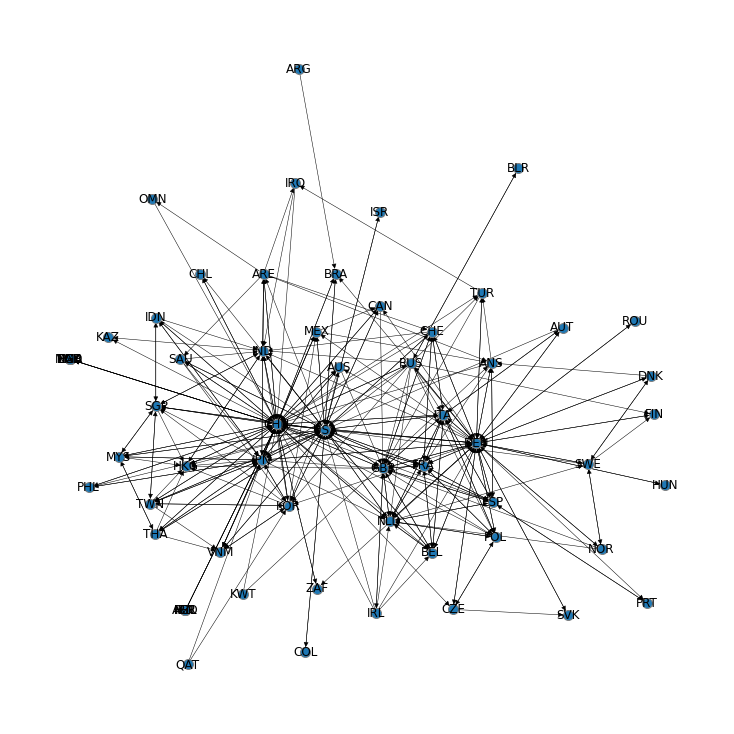

In [10]:
# Visualizamos la red
plt.figure(figsize=(10, 10))
nx.draw_kamada_kawai(G, with_labels=True, node_size=100, width=0.5, edgecolors='gray')


#### Calculos de centralidades de la red de exportaciones principales

In [11]:
G = nx.from_pandas_edgelist(red_exp, source='location_code', target='partner_code', edge_attr='value',
                           create_using=nx.DiGraph())# Degree Centrality

results = pd.DataFrame(dict(
    DEGREE = dict(G.degree),
    DEGREE_CENTRALITY = nx.degree_centrality(G),
    IN_DEGREE_CENTRALITY = nx.in_degree_centrality(G),
    OUT_DEGREE_CENTRALITY = nx.out_degree_centrality(G),
    EIGENVECTOR = nx.eigenvector_centrality(G),
    BETWEENNESS_CENTRALITY = nx.betweenness_centrality(G),
    CLUSTCOEF = nx.clustering(G),
)) 


In [12]:
results.sort_values(by="DEGREE", ascending = False).head(10)

,DEGREE,DEGREE_CENTRALITY,IN_DEGREE_CENTRALITY,OUT_DEGREE_CENTRALITY,EIGENVECTOR,BETWEENNESS_CENTRALITY,CLUSTCOEF
NLD,446,1.905983,0.952991,0.952991,0.098325,0.016451,0.506605
DEU,442,1.888889,0.944444,0.944444,0.098190,0.015142,0.514809
GBR,440,1.880342,0.940171,0.940171,0.098189,0.013655,0.519510
FRA,440,1.880342,0.940171,0.940171,0.097965,0.016847,0.517061
USA,440,1.880342,0.940171,0.940171,0.097293,0.025234,0.510461
ITA,436,1.863248,0.931624,0.931624,0.098010,0.012690,0.527671
CAN,434,1.854701,0.927350,0.927350,0.097394,0.014226,0.526796
ESP,434,1.854701,0.927350,0.927350,0.097891,0.012350,0.531362
SGP,434,1.854701,0.927350,0.927350,0.097391,0.013070,0.526156
THA,428,1.829060,0.914530,0.914530,0.097381,0.013445,0.541617


#### Matriz País-Producto

In [13]:
data.head(5)

,location_id,partner_id,location_code,partner_code,product_id,sitc_product_code,export_value,import_value
0,0,1,ABW,AFG,670,230,2124,0
1,7,1,ARE,AFG,670,230,88420,0
2,61,1,DEU,AFG,670,230,19988,0
3,64,1,DNK,AFG,670,230,158738,0
4,162,1,NLD,AFG,670,230,123476,0


In [14]:
data_m = data[['location_code', 'product_id', 'export_value']]
data_m.head(5)

,location_code,product_id,export_value
0,ABW,670,2124
1,ARE,670,88420
2,DEU,670,19988
3,DNK,670,158738
4,NLD,670,123476


In [15]:
mat = pd.pivot_table(data_m, values = 'export_value', index = 'location_code', columns = 'product_id', aggfunc=np.sum, fill_value = 0)
#m_pp.set_index('location_code')
#m_pp = m_pp.iloc[: , 1:]
mat.head()


product_id,650,651,652,653,654,656,657,658,659,660,...,1426,1427,1428,1429,1430,1432,1433,1434,1435,1436
location_code,,,,,,,,,,,,,,,,,,,,,
ABW,0,0,0,47855,13643,0,0,0,24930,0,...,4233,446469,4914,0,1267,13002331,4675,8528,0,683060
AFG,0,156300,0,0,0,82541,1344,0,0,0,...,0,0,51832,0,249694,9119616,307209,24835,0,132503912
AGO,0,0,0,0,14758,92504,0,0,25595,0,...,4497,10571,81657,0,21337,9773685,712531,121765,0,2446826
AIA,0,0,0,0,0,68017,0,0,0,0,...,16256,182452,29803,31929,2698,358276,0,0,0,20955
ALB,0,19535,0,0,0,254524,0,0,5341,257488,...,20617,826296,1503056,60749,1595,371960990,710134,0,0,1071930


#### REVEALED COMPARATIVE ADVANTAGE (RCA) 
One way to empirically estimate whether a country is a significant exporter of a product is
to calculate the Revealed Comparative Advantage (RCA) that that country has in a particular
product.

In [16]:
# Delete columns and rows that sum zero
mat.loc[(mat.sum(axis=1) != 0), (mat.sum(axis=0) != 0)]

product_id,650,651,652,653,654,656,657,658,659,660,...,1426,1427,1428,1429,1430,1432,1433,1434,1435,1436
location_code,,,,,,,,,,,,,,,,,,,,,
ABW,0,0,0,47855,13643,0,0,0,24930,0,...,4233,446469,4914,0,1267,13002331,4675,8528,0,683060
AFG,0,156300,0,0,0,82541,1344,0,0,0,...,0,0,51832,0,249694,9119616,307209,24835,0,132503912
AGO,0,0,0,0,14758,92504,0,0,25595,0,...,4497,10571,81657,0,21337,9773685,712531,121765,0,2446826
AIA,0,0,0,0,0,68017,0,0,0,0,...,16256,182452,29803,31929,2698,358276,0,0,0,20955
ALB,0,19535,0,0,0,254524,0,0,5341,257488,...,20617,826296,1503056,60749,1595,371960990,710134,0,0,1071930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,0,0,2077,0,0,42266,42902,4225,109972,0,...,95926,0,32401,0,4092,2121172,0,0,0,0
YEM,0,0,0,0,0,0,0,0,0,0,...,0,1422,93234,4676,0,949592,0,44504,0,77008096
ZAF,19786822,8500982,795580,10177921,9090556,90812752,5110304,23537757,76922114,0,...,7116134,26100693,21476415,10310174,31097790,507078389,18503541,143694489,30748516,16003504146


In [17]:
## RCA - PART BY PART

rowSums = mat.sum(axis=1) 
colSums = mat.sum(axis=0) 
dataSums = mat.values.sum()

## RCA - ALL TOGETHER (Normalize)
RCA = mat.div(rowSums, axis=0).T.div((mat.sum() / mat.values.sum()),axis=0).T

# Convert RCA to 1s and 0s
RCA = (RCA.mask(RCA >= 1, 1)) 
RCA = (RCA.mask(RCA < 1, 0))
RCA.head(n=5)

product_id,650,651,652,653,654,656,657,658,659,660,...,1426,1427,1428,1429,1430,1432,1433,1434,1435,1436
location_code,,,,,,,,,,,,,,,,,,,,,
ABW,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
AFG,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
AGO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ALB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### PROXIMITY / SIMILARITY

In [21]:
# -----------------------------
# Proximity - PRODUCTS
# -----------------------------

norms = RCA.sum()
norm = np.maximum.outer(norms.values, norms.values)
proximity = RCA.T.dot(RCA).div(norm)

# ----------------------------- 
# Cosine Similarity - PRODUCTS
# -----------------------------

norms = np.linalg.norm(RCA, axis=0)
norm = np.outer(norms, norms)
cosine = RCA.T.dot(RCA).div(norm)

proximity

product_id,650,651,652,653,654,656,657,658,659,660,...,1426,1427,1428,1429,1430,1432,1433,1434,1435,1436
product_id,,,,,,,,,,,,,,,,,,,,,
650,1.000000,0.413043,0.326087,0.369565,0.217391,0.326087,0.260870,0.260870,0.326087,0.326087,...,0.065217,0.217391,0.108696,0.108696,0.065217,0.245614,0.381818,0.282609,0.304348,0.217391
651,0.413043,1.000000,0.096774,0.257143,0.129032,0.161290,0.387097,0.064516,0.225806,0.193548,...,0.000000,0.096774,0.000000,0.064516,0.032258,0.105263,0.254545,0.161290,0.162162,0.202899
652,0.326087,0.096774,1.000000,0.257143,0.250000,0.200000,0.125000,0.470588,0.241379,0.291667,...,0.117647,0.142857,0.185185,0.277778,0.047619,0.105263,0.163636,0.280000,0.135135,0.043478
653,0.369565,0.257143,0.257143,1.000000,0.200000,0.257143,0.171429,0.342857,0.371429,0.257143,...,0.057143,0.342857,0.171429,0.171429,0.028571,0.175439,0.345455,0.285714,0.270270,0.072464
654,0.217391,0.129032,0.250000,0.200000,1.000000,0.320000,0.291667,0.300000,0.206897,0.333333,...,0.050000,0.392857,0.111111,0.100000,0.047619,0.175439,0.163636,0.080000,0.162162,0.072464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,0.245614,0.105263,0.105263,0.175439,0.175439,0.175439,0.105263,0.157895,0.157895,0.157895,...,0.070175,0.228070,0.087719,0.035088,0.035088,1.000000,0.280702,0.157895,0.263158,0.159420
1433,0.381818,0.254545,0.163636,0.345455,0.163636,0.181818,0.181818,0.145455,0.145455,0.145455,...,0.036364,0.163636,0.163636,0.054545,0.054545,0.280702,1.000000,0.163636,0.218182,0.318841
1434,0.282609,0.161290,0.280000,0.285714,0.080000,0.240000,0.120000,0.280000,0.241379,0.240000,...,0.120000,0.214286,0.074074,0.160000,0.000000,0.157895,0.163636,1.000000,0.243243,0.101449


In [22]:
RCA_c = RCA.T

# -----------------------------
# Proximity - COUNTRIES
# -----------------------------

norms = RCA_c.sum()
norm = np.maximum.outer(norms.values, norms.values)
proximity = RCA_c.T.dot(RCA_c).div(norm)

# ----------------------------- 
# Cosine Similarity - COUNTRIES
# -----------------------------

norms = np.linalg.norm(RCA_c, axis=0)
norm = np.outer(norms, norms)
cosine = RCA_c.T.dot(RCA_c).div(norm)

proximity

location_code,ABW,AFG,AGO,AIA,ALB,AND,ANS,ARE,ARG,ARM,...,VEN,VGB,VNM,VUT,WLF,WSM,YEM,ZAF,ZMB,ZWE
location_code,,,,,,,,,,,,,,,,,,,,,
ABW,1.000000,0.029851,0.000000,0.060000,0.081081,0.116279,0.080000,0.160000,0.031496,0.120000,...,0.080000,0.080000,0.068323,0.060000,0.040000,0.136986,0.080000,0.042683,0.064935,0.084746
AFG,0.029851,1.000000,0.014925,0.000000,0.207207,0.081395,0.014925,0.134328,0.267717,0.173333,...,0.059701,0.014925,0.093168,0.074627,0.000000,0.136986,0.223881,0.182927,0.155844,0.253731
AGO,0.000000,0.014925,1.000000,0.000000,0.018018,0.000000,0.000000,0.075000,0.007874,0.013333,...,0.040000,0.032258,0.006211,0.050000,0.142857,0.013699,0.042553,0.012195,0.025974,0.050847
AIA,0.060000,0.000000,0.000000,1.000000,0.018018,0.069767,0.068182,0.025000,0.000000,0.013333,...,0.040000,0.032258,0.031056,0.000000,0.000000,0.013699,0.021277,0.012195,0.025974,0.000000
ALB,0.081081,0.207207,0.018018,0.018018,1.000000,0.144144,0.045045,0.063063,0.196850,0.270270,...,0.090090,0.018018,0.329193,0.036036,0.000000,0.189189,0.153153,0.189024,0.144144,0.207207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,0.136986,0.136986,0.013699,0.013699,0.189189,0.093023,0.068493,0.068493,0.110236,0.186667,...,0.095890,0.041096,0.161491,0.095890,0.000000,1.000000,0.136986,0.109756,0.090909,0.109589
YEM,0.080000,0.223881,0.042553,0.021277,0.153153,0.069767,0.021277,0.148936,0.165354,0.120000,...,0.212766,0.021277,0.105590,0.106383,0.000000,0.136986,1.000000,0.085366,0.155844,0.186441
ZAF,0.042683,0.182927,0.012195,0.012195,0.189024,0.085366,0.030488,0.097561,0.304878,0.164634,...,0.042683,0.036585,0.176829,0.036585,0.006098,0.109756,0.085366,1.000000,0.262195,0.213415


In [23]:
data_m.head(3)

,location_code,product_id,export_value
0,ABW,670,2124
1,ARE,670,88420
2,DEU,670,19988


In [42]:
RCA_n = RCA.stack().reset_index().rename(columns={'level_0':'Source','level_1':'Target', 0:'export_value'})

In [65]:
comp = econci.Complexity(RCA_n, c='location_code', p='product_id', values='export_value')
comp.calculate_indexes()
eci = comp.eci
pci = comp.pci

# creating the product space
comp.create_product_space()

# the graphs are networkx.Graph objects
complete_graph = comp.complete_graph  # complete product space
max_spanning_tree = comp.maxst  # maximum spanning tree
prod_space = comp.product_space  # product space

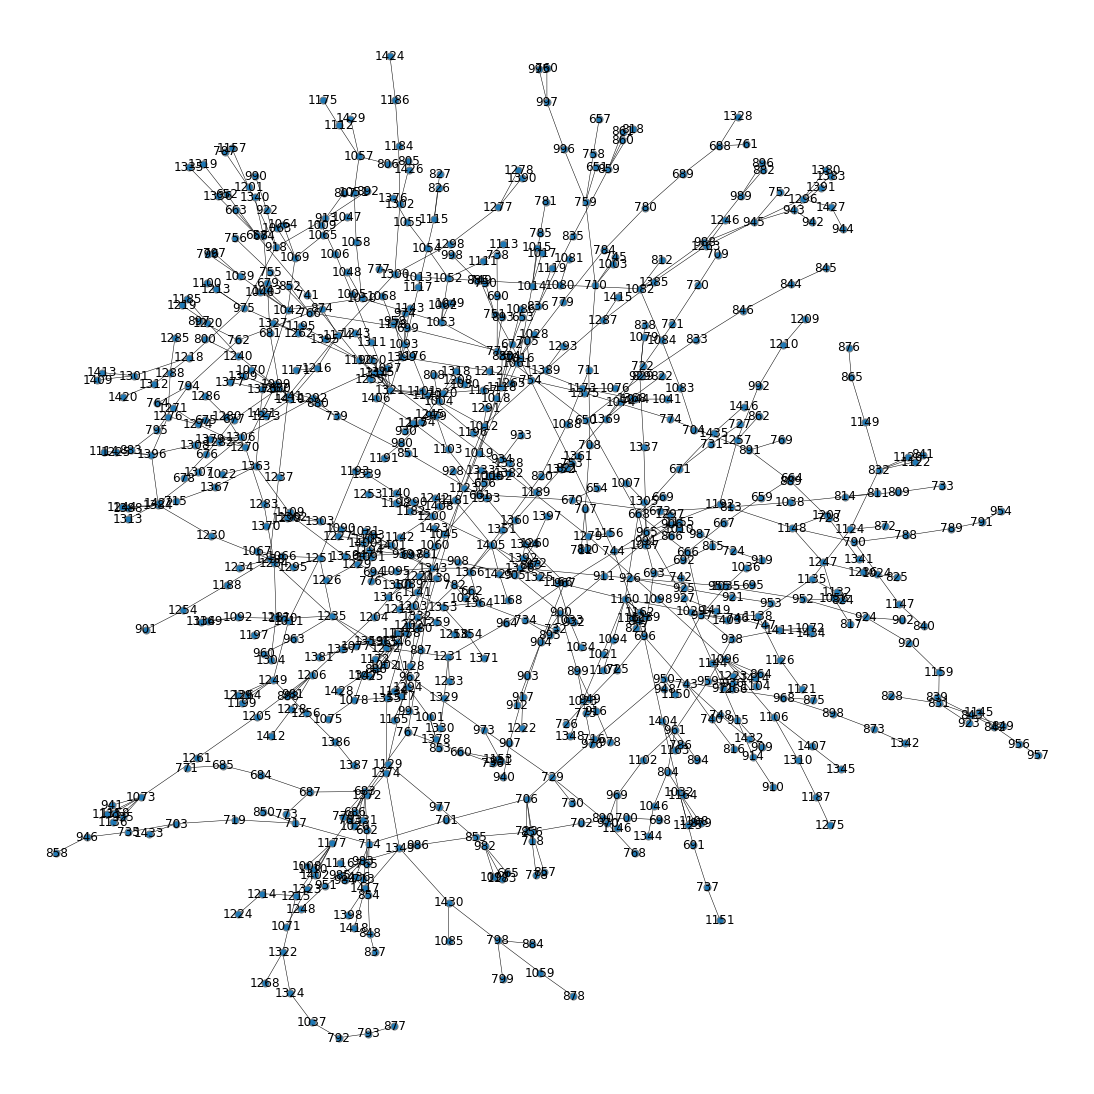

In [72]:
plt.figure(figsize=(15, 15))
nx.draw(max_spanning_tree, with_labels=True, node_size=50, width=0.5, edgecolors='gray')


In [44]:
eci.sort_values(by="eci", ascending = False)

,location_code,eci
183,SGS,2.727526
110,JPN,2.109108
229,WLF,2.052938
215,TWN,1.956559
11,ATA,1.887916
...,...,...
104,IRQ,-2.054736
85,GNB,-2.284942
83,GIN,-2.387345
192,SSD,-2.522290


In [64]:
prodspace_data = pd.DataFrame.from_dict(prod_space.edges, orient='index').reset_index()
prodspace_data.columns = ['source', 'target', 'weight']

prodspace_data.to_csv(path+'product_space.csv', index = False)

prodspace_data

,source,target,weight
0,650,668,0.541667
1,650,772,0.479167
2,650,829,0.434783
3,651,759,0.441176
4,652,658,0.470588
...,...,...,...
841,1425,1168,0.388889
842,1426,1302,0.315789
843,1429,1057,0.476190
844,1430,798,0.428571


In [67]:
complete_graph_data = pd.DataFrame.from_dict(complete_graph.edges, orient='index').reset_index()
complete_graph_data.columns = ['source', 'target', 'weight']

complete_graph_data.to_csv(path+'complete_graph.csv', index = False)

In [68]:
max_spanning_tree_data = pd.DataFrame.from_dict(max_spanning_tree.edges, orient='index').reset_index()
max_spanning_tree_data.columns = ['source', 'target', 'weight']

max_spanning_tree_data.to_csv(path+'max_spanning_tree.csv', index = False)